In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from scipy import stats
from scipy.special import boxcox1p
from scipy import signal
from statsmodels.tsa import stattools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from datetime import datetime, timedelta
from itertools import product
from sklearn.metrics import mean_squared_error
from numpy.linalg import LinAlgError

In [3]:
data = pd.read_csv('transactions.csv')
data

,isFraud,TransactionDT,TransactionAmt,D1,D2,D3,card1,card2,card3,addr1,addr2,V104,V105,V106
0,0,86506,50.000,0.0,NaN,NaN,4497,514.0,150.0,420.0,87.0,0.0,0.0,0.0
1,0,86761,39.000,0.0,NaN,NaN,7875,314.0,150.0,299.0,87.0,0.0,0.0,0.0
2,0,86821,73.950,66.0,66.0,35.0,10112,360.0,150.0,264.0,87.0,0.0,0.0,0.0
3,0,87135,107.950,245.0,245.0,245.0,17359,555.0,150.0,469.0,87.0,0.0,0.0,0.0
4,0,87557,35.950,0.0,NaN,NaN,9785,343.0,150.0,485.0,87.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59049,0,15810350,92.000,3.0,3.0,4.0,2377,203.0,150.0,110.0,87.0,0.0,0.0,0.0
59050,0,15810372,117.000,472.0,471.0,6.0,12873,535.0,150.0,299.0,87.0,0.0,0.0,0.0
59051,0,15810912,73.838,0.0,NaN,NaN,5096,555.0,185.0,NaN,NaN,0.0,0.0,0.0
59052,0,15811007,204.970,315.0,315.0,315.0,12037,595.0,150.0,231.0,87.0,0.0,0.0,0.0


<u>Step 1.</u> Choose about 3-6 variables from your dataset (2-3 – target variables, the rest -
predictors).

In [4]:
data4 = data[['TransactionDT', 'TransactionAmt', 'D1', 'D3', 'card3']].dropna()
data4.index = [i for i in range(data4.shape[0])]

date = 'TransactionDT'
target = ['TransactionAmt', 'D1']
predictors = ['D3', 'card3']

data4[date] = pd.to_datetime(data4[date] * 1e9).dt.round('1d')

data4

,TransactionDT,TransactionAmt,D1,D3,card3
0,1970-01-02,73.95,66.0,35.0,150.0
1,1970-01-02,107.95,245.0,245.0,150.0
2,1970-01-02,250.00,238.0,0.0,150.0
3,1970-01-02,107.00,57.0,56.0,150.0
4,1970-01-02,159.00,40.0,9.0,150.0
...,...,...,...,...,...
32492,1970-07-03,49.00,16.0,17.0,150.0
32493,1970-07-03,92.00,3.0,4.0,150.0
32494,1970-07-03,117.00,472.0,6.0,150.0
32495,1970-07-03,204.97,315.0,315.0,150.0


In [5]:
data4agg = data4.groupby(date, as_index=False).sum()
data4agg

,TransactionDT,TransactionAmt,D1,D3,card3
0,1970-01-02,16590.003,10690.0,2548.0,11242.0
1,1970-01-03,36695.067,50338.0,7165.0,44074.0
2,1970-01-04,20554.369,31885.0,6395.0,30749.0
3,1970-01-05,23726.664,40007.0,4991.0,31147.0
4,1970-01-06,28894.698,40487.0,6943.0,35670.0
...,...,...,...,...,...
178,1970-06-29,17421.274,25246.0,4006.0,22655.0
179,1970-06-30,18579.873,32790.0,5011.0,23739.0
180,1970-07-01,22930.026,31602.0,3675.0,25779.0
181,1970-07-02,23678.988,28732.0,3677.0,26047.0


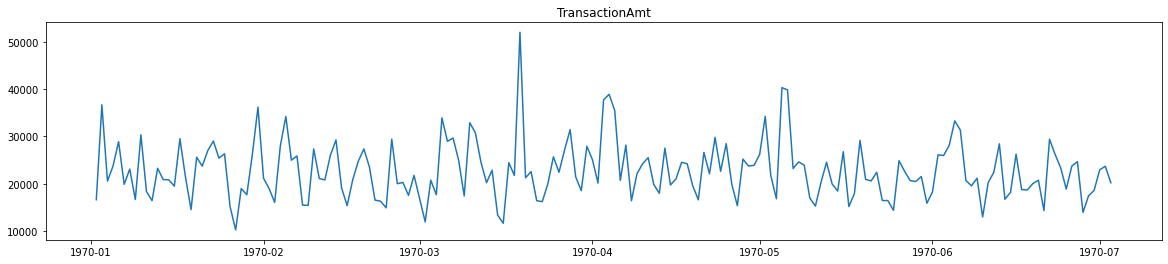

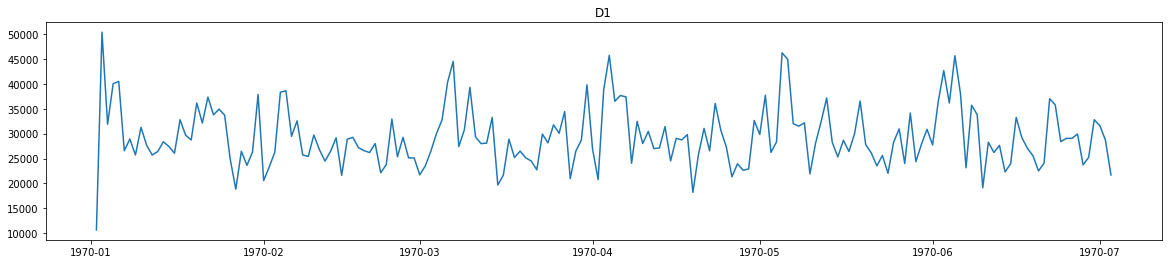

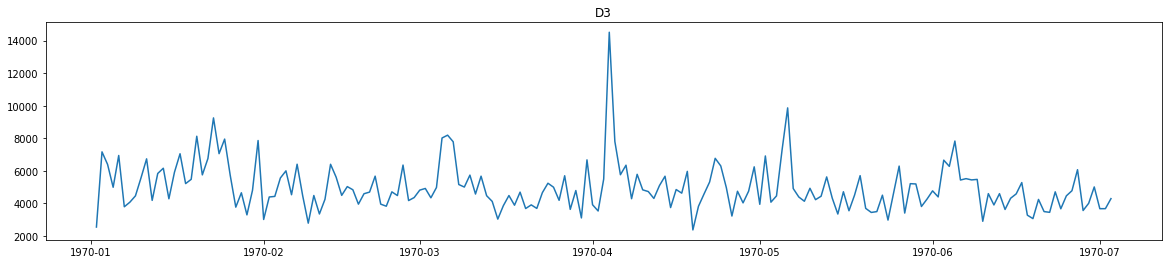

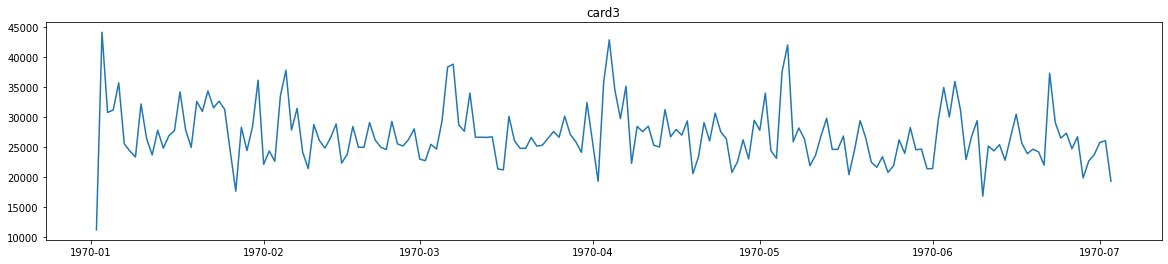

In [6]:
for f in target + predictors:
    plt.figure(figsize=(20, 4))
    plt.title(f)
    plt.plot(data4agg[date], data4agg[f])
    plt.show()

<u>Step 2.</u> Analyze stationarity of a process (for mathematical expectation and variance) for all
chosen variables. Make them more stationary if needed.

In [7]:
p_threshold = 0.005

In [8]:
lmbds = {f: None for f in target + predictors}

In [9]:
print("Let's use augmented Dickey-Fuller test with threshold", p_threshold, "for p-value to check the stationarity")

for f in target + predictors:
    adf_result = smt.stattools.adfuller(data4agg[f])
    print('Augmented Dickey-Fuller test for %s:\nStatistic value = %5f\np-value = %5f' % (f, adf_result[0], adf_result[1]))
    if adf_result[1] < p_threshold:
        print('%s is stationary\n' % f)
    else:
        print('%s is not stationary\nData will be normalized' % f)
        data4agg[f], lmbds[f] = stats.boxcox(data4agg[f])
        print('Chosen BoxCox lambda:', lmbds[f], '\n')
        # data4agg[f] -= data4agg[f].shift(1).fillna(0)

Let's use augmented Dickey-Fuller test with threshold 0.005 for p-value to check the stationarity
Augmented Dickey-Fuller test for TransactionAmt:
Statistic value = -3.143129
p-value = 0.023522
TransactionAmt is not stationary
Data will be normalized
Chosen BoxCox lambda: -0.11931956539735275 

Augmented Dickey-Fuller test for D1:
Statistic value = -4.500556
p-value = 0.000196
D1 is stationary

Augmented Dickey-Fuller test for D3:
Statistic value = -9.995221
p-value = 0.000000
D3 is stationary

Augmented Dickey-Fuller test for card3:
Statistic value = -4.764334
p-value = 0.000064
card3 is stationary



<u>Step 3.</u> Analyze covariance or correlation function for chosen target variables and mutual
correlation functions among predictors and targets.

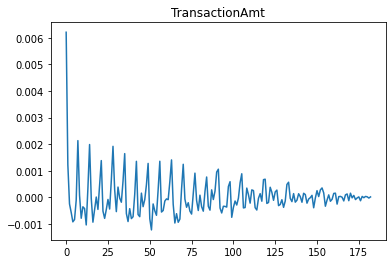

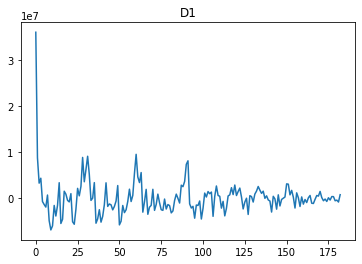

In [10]:
for t in target:
    plt.plot(stattools.acovf(data4agg[t], fft=False))
    plt.title(t)
    plt.show()

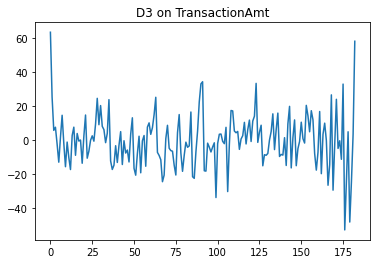

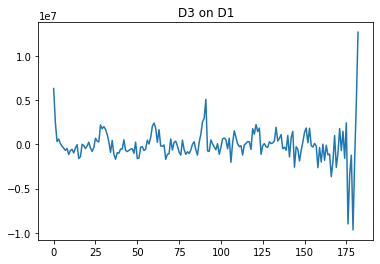

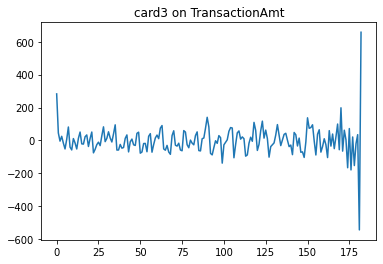

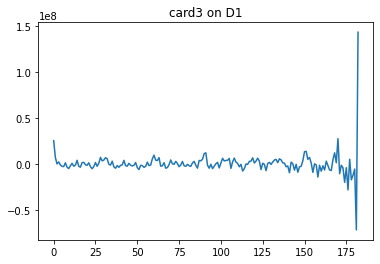

In [11]:
for p in predictors:
    for t in target:
        plt.plot(stattools.ccovf(data4agg[p], data4agg[t]))
        plt.title(p + ' on ' + t)
        plt.show()

<u>Step 4.</u> Filter high frequencies (noise) with chosen 2 filters for target variables.

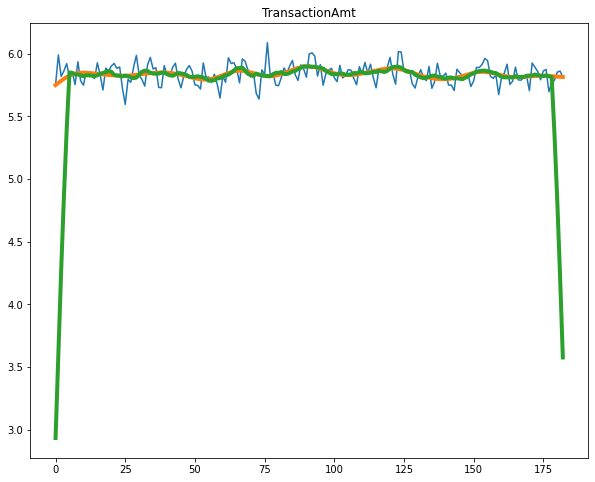

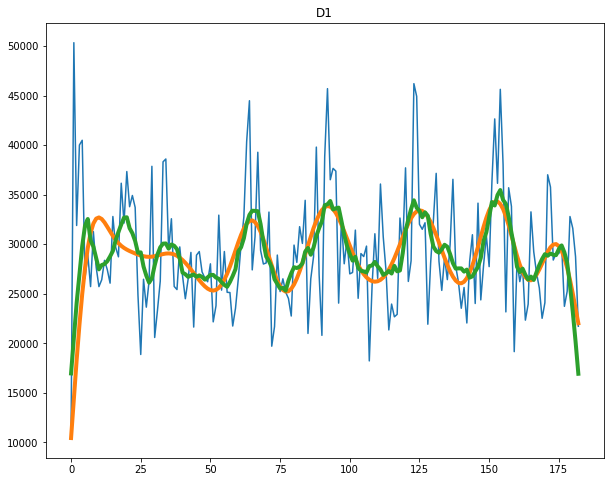

In [12]:
fs = 100 #sampling frequency
fc = 5  #cut frequency
w = fc / (fs / 2) #normalisation
b, a = signal.butter(5, w, 'low')

#gauss filter parameters
windows_size = 10
gauss_sd = 5
#windows setup
window = signal.gaussian(windows_size, gauss_sd)

for t in target:
    data4agg[t + '_btw'] = signal.filtfilt(b, a, data4agg[t])
    data4agg[t + '_gauss'] = signal.convolve(data4agg[t], window / window.sum(), mode='same')

    plt.figure(figsize=(10, 8))
    plt.plot(data4agg[t])
    plt.plot(data4agg[t + '_btw'], linewidth=4)
    plt.plot(data4agg[t + '_gauss'], linewidth=4)
    plt.title(t)
    plt.show()

<u>Step 5.</u> Estimate spectral density function for with and without filtering.

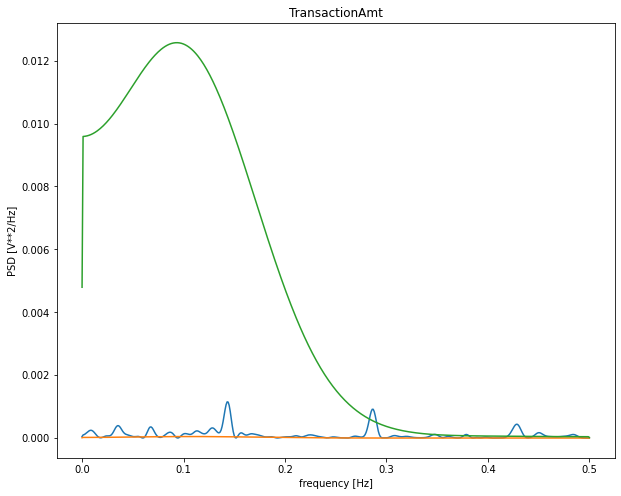

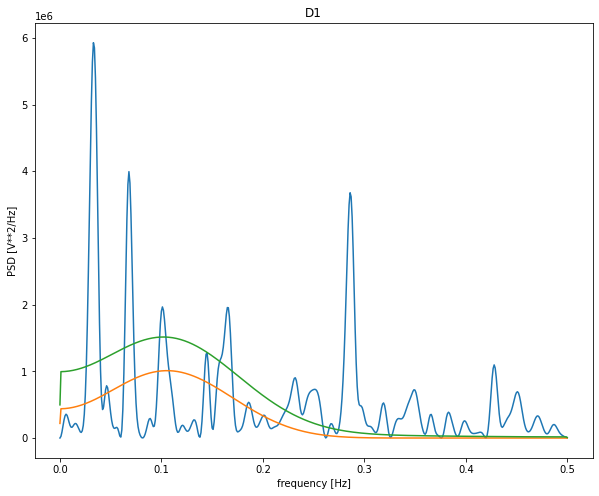

In [13]:
blackman = signal.blackman(M=windows_size)

for t in target:
    f, Pxx = signal.welch(data4agg[t], fs=1, scaling='spectrum', nfft = 1000)
    f_btw, Pxx_btw = signal.welch(data4agg[t + '_btw'], fs=1, window=blackman, nfft = 1000, scaling='spectrum')
    f_gauss, Pxx_gauss = signal.welch(data4agg[t + '_gauss'], fs=1, window=blackman, nfft = 1000, scaling='spectrum')

    plt.figure(figsize=(10, 8))
    plt.plot(f, Pxx)
    plt.plot(f_btw, Pxx_btw)
    plt.plot(f_gauss, Pxx_gauss)
    plt.title(t)

    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

<u>Step 6.</u> Built auto-regression model filtered and non-filtered data. To analyze residual error
and to define appropriate order of model.

In [14]:
# SARIMA parameters:

ps = range(0, 6)
d = 1
qs = range(0, 6)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(u"Models to analyse by AIC:", len(parameters_list))

Models to analyse by AIC: 72


In [15]:
targetf = target + [t + '_btw' for t in target] + [t + '_gauss' for t in target]
best_model = {t: None for t in targetf}
best_param = {t: None for t in targetf}

for t in targetf:
    best_aic = float("inf")
    for param in parameters_list:
        #try except for the case of wrong parameters
        try:
            model = sm.tsa.statespace.SARIMAX(data4agg[t],
                                              order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        except ValueError:
            continue
        except LinAlgError:
            continue
        aic = model.aic

        # save best model, aic, parameters
        if (aic < best_aic):
            best_model[t] = model
            best_param[t] = param
            best_aic = aic

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [16]:
for t in targetf:
    print('\n\n============\n' + t + '\n============\n\n')
    print(best_model[t].summary())



TransactionAmt


                                 Statespace Model Results                                 
Dep. Variable:                     TransactionAmt   No. Observations:                  183
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                 166.282
Date:                            Sun, 18 Apr 2021   AIC                           -308.564
Time:                                    13:44:54   BIC                           -270.934
Sample:                                         0   HQIC                          -293.294
                                            - 183                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5635      0.215     -2.616      0.009      -0.986      -0.141
ar.L2          0

In [17]:
for t in targetf:
    print(t + ':', mean_squared_error(best_model[t].predict(), data4agg[t]))

TransactionAmt: 0.23593585112964163
D1: 63139195.487360135
TransactionAmt_btw: 0.22583153182001503
D1_btw: 810692.0665908238
TransactionAmt_gauss: 0.07313318827667688
D1_gauss: 2808739.2692809436


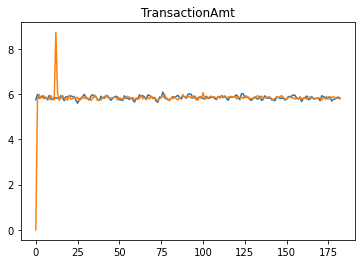

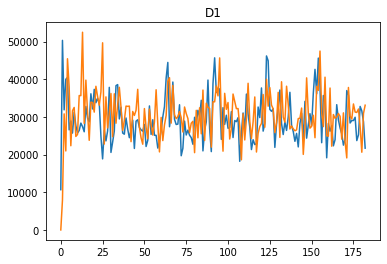

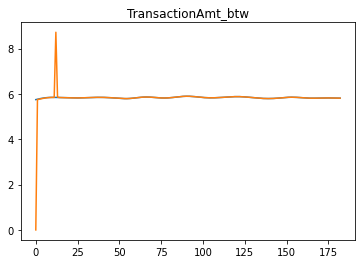

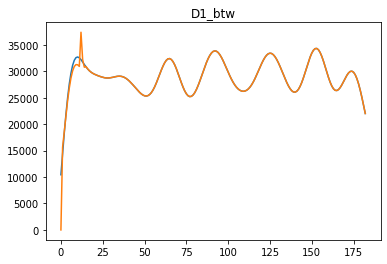

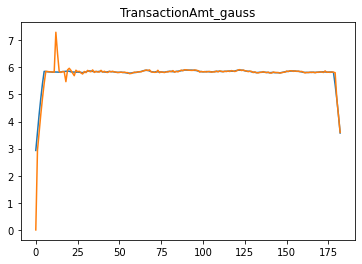

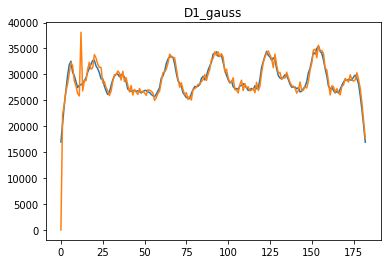

In [18]:
for t in targetf:
    plt.plot(data4agg[t])
    plt.plot(best_model[t].predict())
    plt.title(t)
    plt.show()

<u>Step 7.</u> Build model in a form of linear dynamical system, using chosen predictors. To analyze
residual error and to define appropriate order of model.

In [19]:
test_size = 50
train, test = data4agg[target + predictors][:-test_size], data4agg[target + predictors][-test_size:]
history = train
predictions = []

for t in range(test_size):
    model = VAR(endog=history)
    model_fit = model.fit(maxlags=16)
    output = model_fit.forecast(model_fit.y, steps=1)
    yhat = output[0]
    predictions += [yhat]
    obs = test.iloc[t]
    history = history.append(obs)

In [20]:
for i, t in enumerate(target):
    print(t + ':', mean_squared_error(test[t], [p[i] for p in predictions]))

TransactionAmt: 0.006427620739079456
D1: 42206718.66307126


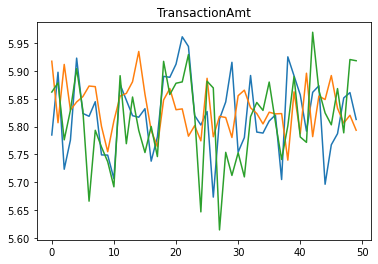

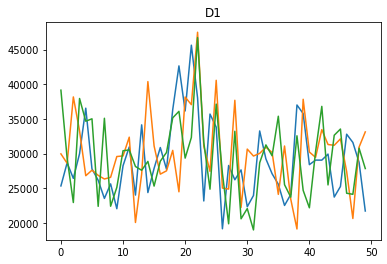

In [21]:
for i, t in enumerate(target):
    plt.plot(test[t].tolist())
    plt.plot(best_model[t].predict()[-test_size:].tolist())
    plt.plot([p[i] for p in predictions])
    plt.title(t)
    plt.show()